This notebook reproduces the Lorentz results from [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116). The data generation is specified in the  [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) of [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116), and is restated here. 


The data was syntheticaly generated using the governing lorentz
equations


$$
\begin{aligned}
\dot{z}_1 =& \sigma (z_2 - z_1) \\



\dot{z}_2 =& z_1 (\rho - z_3) - z_2 \\



\dot{z}_3 =& z_1 z_2 - \beta z_3 \\

\end{aligned}
$$

with the standard paramater values $\sigma = 10$, $\beta = \frac{8}{3}$ and $\rho = 28$

This data is then trnsformed using the first 6 legendre polynomials.


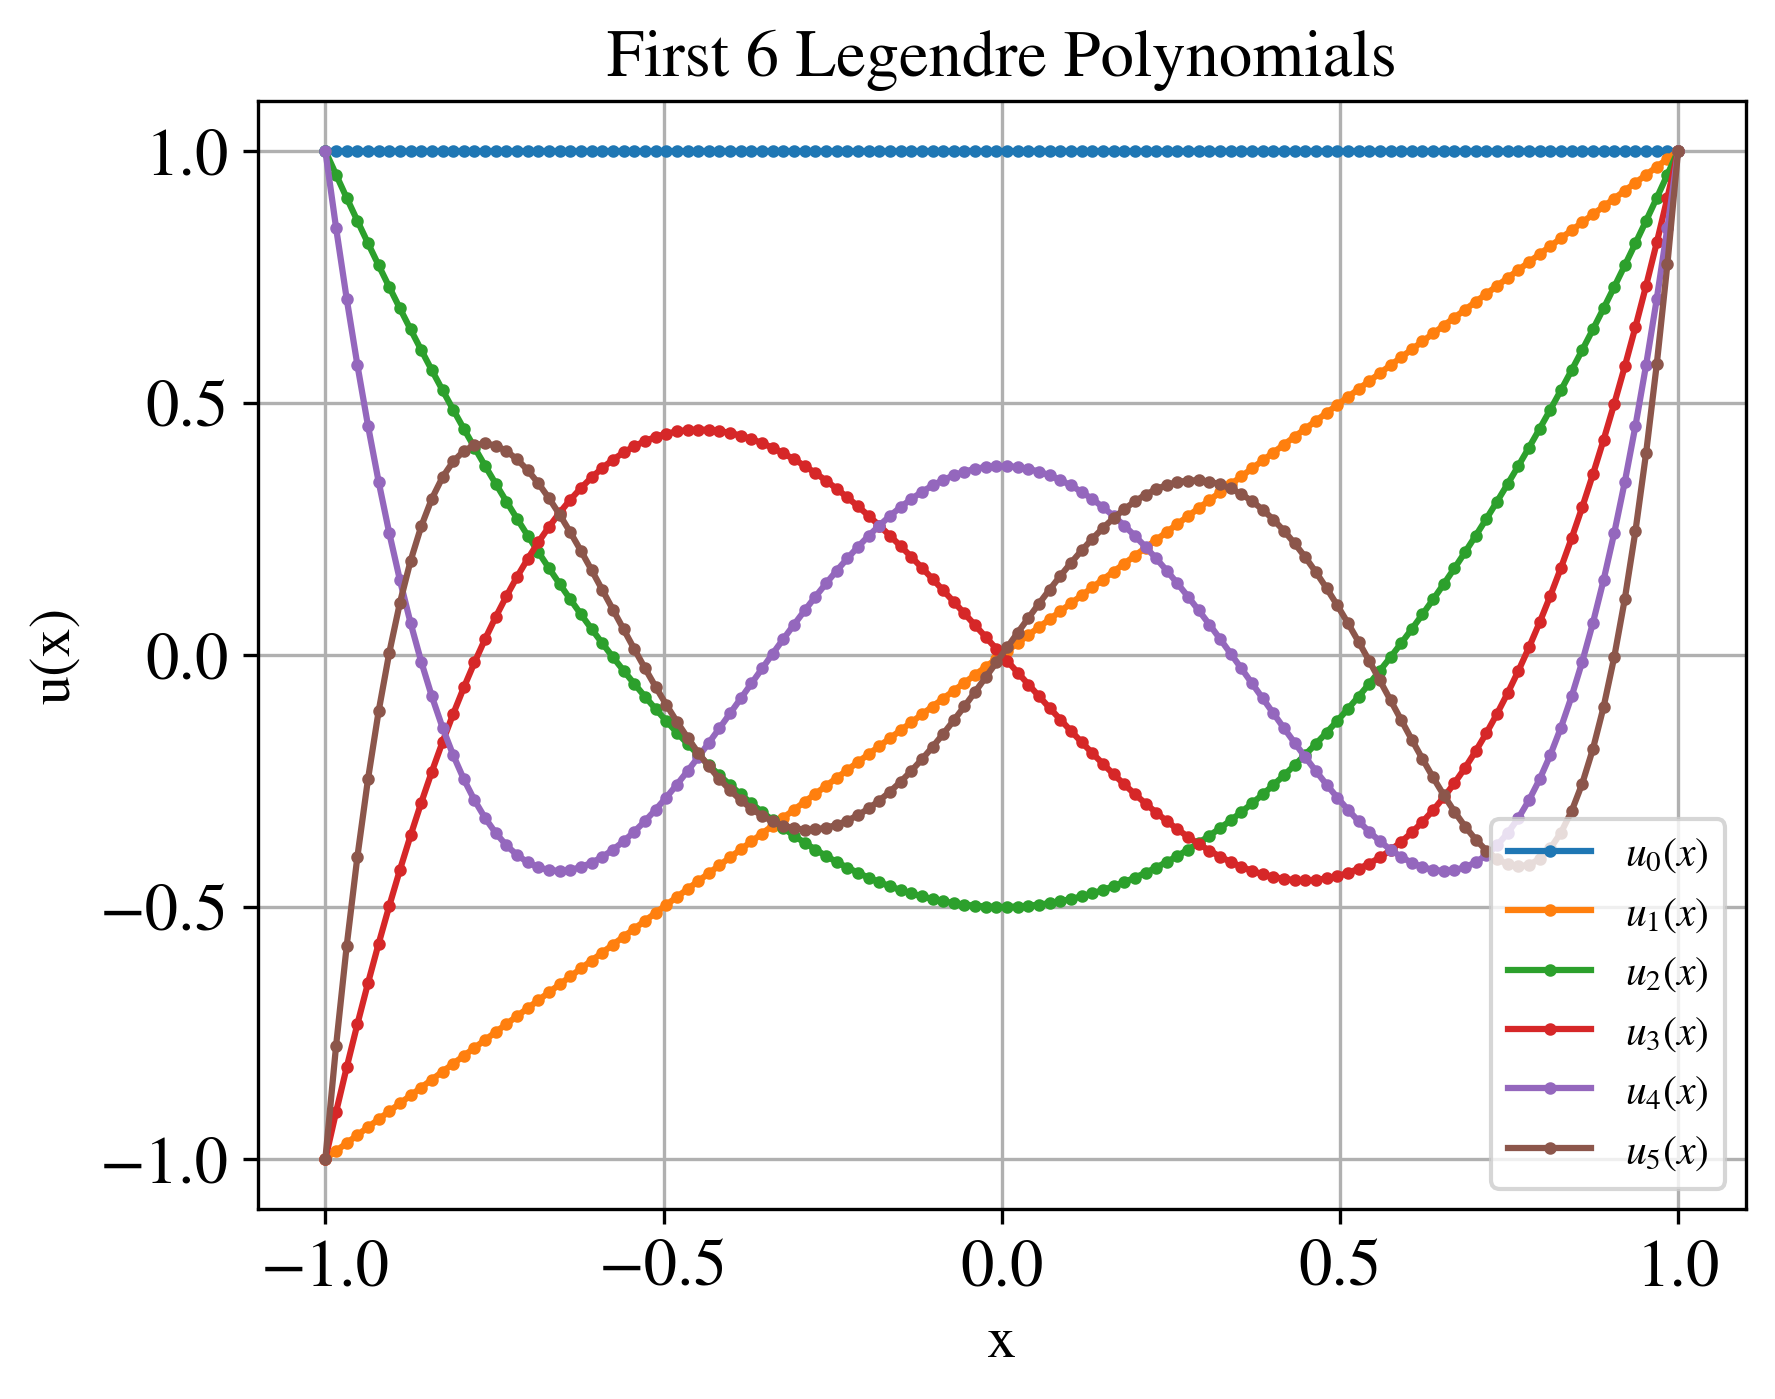

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import legendre

plt.style.use("../plot_utils/plot_settings.mplstyle")

x = np.linspace(-1, 1, 128)

# Plot the first 6 Legendre polynomials
for n in range(6):
    u_n = legendre(n)
    y = u_n(x)
    # Plot the polynomial
    #make the 
    plt.plot(x, y, label=f'$u_{n}(x)$', marker='o', markersize=2)


plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('First 6 Legendre Polynomials')
plt.legend()
plt.grid(True)



Each datapoint $\boldsymbol{z} = [z_1, z_2, z_3]$ is mapped to a $\boldsymbol{x}$ by

$$
\boldsymbol{x}(t) = \boldsymbol{u_1} z_1(t) +  \boldsymbol{u_2}z_2(t) +  \boldsymbol{u_3}z_3(t) +  \boldsymbol{u_4}z_1(t)^3 +  \boldsymbol{u_5}z_2(t)^3 +  \boldsymbol{u_6} z_3(t)^3 
$$

Our $\boldsymbol{u}_n \in \mathbb{R}^{128}$ vectors correspond precisely to the ones depicted above; these are constructed by sampling the $n$-th Legendre polynomial at 128 equally spaced points within the interval $[-1, 1]$.

From the [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) 
"To generate our data set, we simulate the system with 2048 initial conditions for the training set, 20 for the validation set, and 100 for the test set. For each initial condition we integrate the system forward in time from t = 0 to t = 5 with a spacing of ∆t = 0.02 to obtain 250 samples. Initial conditions 93 are chosen randomly from a uniform distribution over $z_1$ ∈ [−36, 36], $z_2$ ∈ [−48, 48], $z_3$ ∈ [−16, 66]. This results in a training 94 set with 512,000 total samples"

The functions for generating such data is taken from [Kathleens github](https://github.com/kpchamp/SindyAutoencoders) and simply wrapped in some simple functions to create pytorch dataloaders.

In [2]:
import sys
sys.path.append('../')
from lorentzTorchData import get_lorenz_dataloader # type: ignore -goofy linitng issue

# generate training, validation, testing data
noise_strength = 1e-6
training_data = get_lorenz_dataloader(3, noise_strength=noise_strength)
validation_data = get_lorenz_dataloader(1, train=False, noise_strength=noise_strength)
testing_data = get_lorenz_dataloader(2, train=False, noise_strength=noise_strength)



In [3]:
sys.path.append('../../src')

from jax import random
# Define the encoder
key = random.PRNGKey(0)
input_dim = 128
latent_dim = 2
poly_order = 3

widths = [60, 40, 20]

#get example input from training_data loader
x, dx = next(iter(training_data)) #x is the example input

batch_size, num_features = x.shape


from sindy_utils import library_size

lib_size = library_size(latent_dim, poly_order=poly_order, use_sine=False)

from autoencoder import Encoder, Decoder, Autoencoder

encoder = Encoder(input_dim, latent_dim, widths)

decoder = Decoder(input_dim, latent_dim, widths)

from loss import create_loss_fn

print("creating loss function")
loss_fn = create_loss_fn(latent_dim=latent_dim, poly_order=poly_order, include_sine=False)

modelhyperparams = {
                    'input_dim': input_dim, 'latent_dim': latent_dim, 
                    'lib_size': lib_size, 'widths': widths, 
                    'encoder': encoder, 'decoder': decoder
}

optimizerhyperparams = {}
logger_params = {}

from trainer import Trainer

trainer = Trainer(Autoencoder, modelhyperparams, optimizerhyperparams, 
                  exmp_input=x, seed=42, logger_params=logger_params, check_val_every_n_epoch=100,
                    update_mask_every_n_epoch=100, loss_fn=loss_fn)



creating loss function

                              Autoencoder Summary                              
┌───────────────┬─────────────┬───────────────┬───────────────┬───────────────┐
│ path          │ module      │ inputs        │ outputs       │ params        │
├───────────────┼─────────────┼───────────────┼───────────────┼───────────────┤
│               │ Autoencoder │ float32[128,… │ -             │ sindy_coeffi… │
│               │             │               │ float32[128,… │ float32[10,2] │
│               │             │               │ -             │               │
│               │             │               │ float32[128,… │ 20 (80 B)     │
├───────────────┼─────────────┼───────────────┼───────────────┼───────────────┤
│ encoder       │ Encoder     │ float32[128,… │ float32[128,… │               │
├───────────────┼─────────────┼───────────────┼───────────────┼───────────────┤
│ encoder/Dens… │ Dense       │ float32[128,… │ float32[128,… │ bias:         │
│               

In [4]:
trainer.train_model(training_data, validation_data, num_epochs=50)

Epochs: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


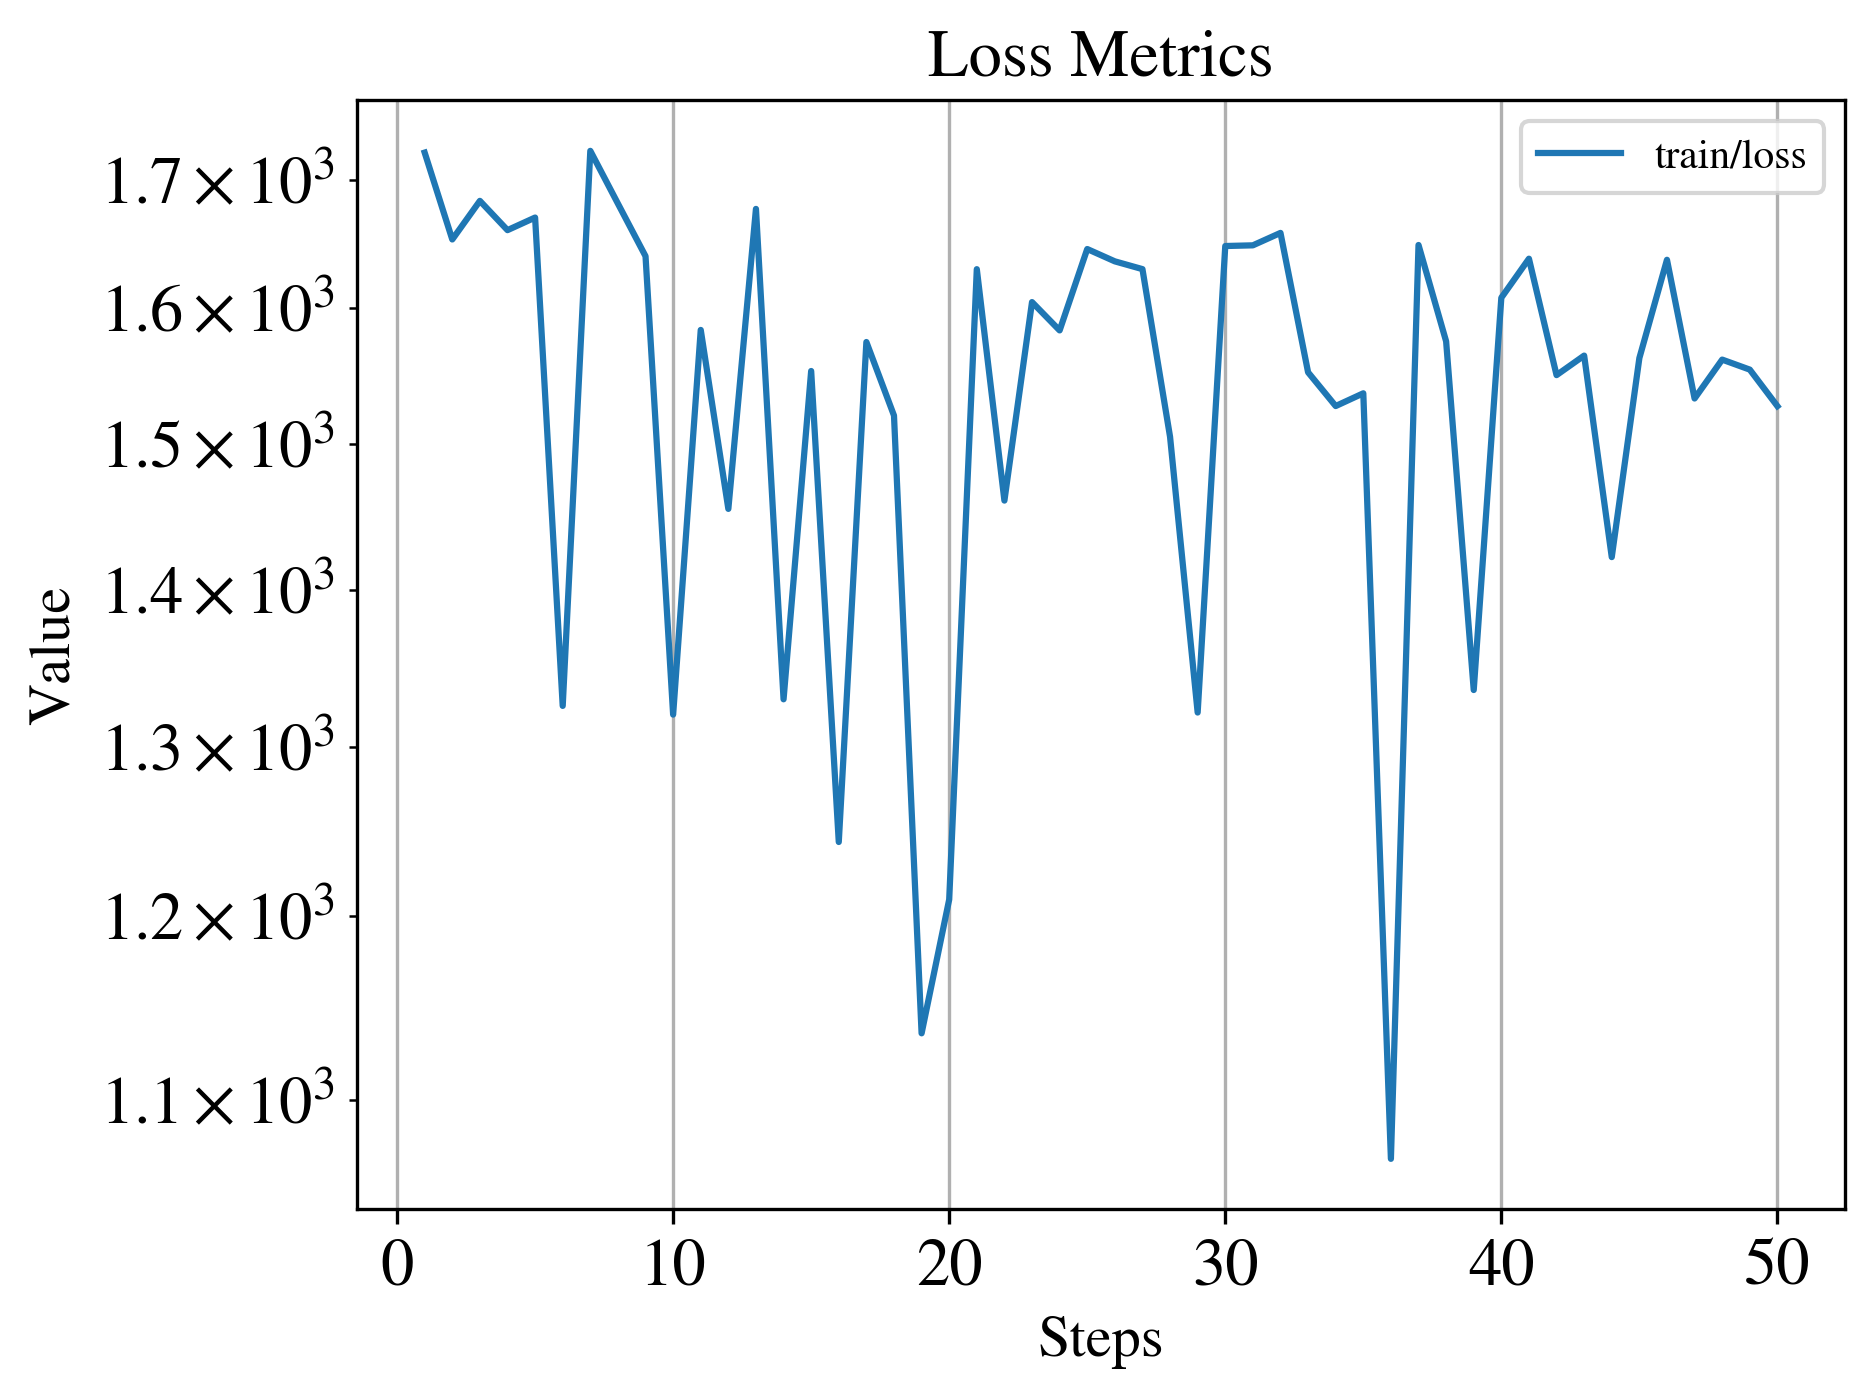

In [5]:
sys.path.append("../plot_utils")
from metrics import RunMetrics # type: ignore -goofy linitng issue
from plot_metrics import plot_metrics # type: ignore -goofy linitng issue

log_dir = trainer.log_dir

metrics = RunMetrics(log_dir)

# Plot a single run
plot_metrics(metrics, metric_names=["train/loss", "val/loss"], title="Loss Metrics")


## Get the sparse representation of the model ($\Xi$ )

In [6]:
mask = trainer.state.mask
xi = trainer.state.params['sindy_coefficients']
xi = xi * mask

print(xi)

[[0.90479136 0.9068974 ]
 [1.1151     1.112109  ]
 [0.85998636 0.86399966]
 [0.9870805  0.9881464 ]
 [1.1171923  1.1157167 ]
 [0.85896057 0.86227447]
 [1.0289956  1.0268377 ]
 [0.8590135  0.86193454]
 [1.0634423  1.0598009 ]
 [1.0846703  1.0815346 ]]


In [7]:
from sindy_utils import get_expression

expression = get_expression(xi, poly_order=poly_order, include_sine=False)
#print(expression)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lorenzUtils import generate_lorenz_data, lorenz_coefficients, simulate_lorenz, get_lorenz_data # type: ignore -goofy linitng issue

# Define the time span and initial conditions
t = np.arange(0, 20, 0.01)
z0 = np.array([[-8, 7, 27]])
params = {'input_dim': 128, 'latent_dim': 3, 'poly_order': 3, 'include_sine': False}

# Generate Lorenz data
test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40, 1/40, 1/40]))


In [9]:
from sindy_utils import sindy_simulate  # Ensure this function is implemented similarly in your JAX code

# Assuming trainer.state.params['sindy_coefficients'] contains the coefficients
xi = trainer.state.params['sindy_coefficients'] * trainer.state.mask

# Simulate the system using the discovered dynamics
z_sim = sindy_simulate(test_data['z'][0], t, xi, params['poly_order'], params['include_sine'])
lorenz_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'], params['poly_order'], params['include_sine'])


MemoryError: 

In [ ]:
# Transform the SINDy coefficients
a1 = 1
a2 = test_data['sindy_coefficients'][2, 0] / xi[2, 0]
a3 = np.sqrt(-xi[5, 2] / xi[6, 1] * a2 ** 2)
b3 = -xi[0, 2] / xi[3, 2]

sindy_coefficients_transformed = np.zeros(xi.shape)
sindy_coefficients_transformed[1, 0] = xi[1, 0]
sindy_coefficients_transformed[2, 0] = xi[2, 0] * a2 / a1
sindy_coefficients_transformed[1, 1] = xi[6, 1] * a1 / a2 * b3
sindy_coefficients_transformed[2, 1] = xi[2, 1]
sindy_coefficients_transformed[6, 1] = xi[6, 1] * a1 * a3 / a2
sindy_coefficients_transformed[3, 2] = xi[3, 2]
sindy_coefficients_transformed[5, 2] = xi[5, 2] * a1 * a2 / a3

z0_transformed = np.array([test_data['z'][0, 0] / a1, test_data['z'][0, 1] / a2, (test_data['z'][0, 2] - b3) / a3])

# Simulate transformed system
z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed, params['poly_order'], params['include_sine'])


In [ ]:

# Plot the simulated results
fig1 = plt.figure(figsize=(3, 3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:, 0], z_sim[:, 1], z_sim[:, 2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3, 3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:, 0], z_sim_transformed[:, 1], z_sim_transformed[:, 2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3, 3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:, 0], lorenz_sim[:, 1], lorenz_sim[:, 2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

# Plot time series comparison
plt.figure(figsize=(3, 3))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t, test_data['z'][:, i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:, i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

# Plot SINDy coefficients
Xi_plot = xi
Xi_plot[Xi_plot == 0] = np.inf
plt.figure(figsize=(1, 2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10, 30])

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot == 0] = np.inf
plt.figure(figsize=(1, 2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10, 30])

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot == 0] = np.inf
Xi_true_plot[6, 1] = -1.
Xi_true_plot[5, 2] = 1.
plt.figure(figsize=(1, 2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10, 30])

plt.show()


In [ ]:
# Assuming test_data contains the necessary fields and trainer has the required outputs
decoder_x_error = np.mean((test_data['x'] - trainer.state.params['x_decoded']) ** 2) / np.mean(test_data['x'] ** 2)
decoder_dx_error = np.mean((test_data['dx'] - trainer.state.params['dx_decoded']) ** 2) / np.mean(test_data['dx'] ** 2)
sindy_dz_error = np.mean((trainer.state.params['dz'] - trainer.state.params['dz_predict']) ** 2) / np.mean(trainer.state.params['dz'] ** 2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy relative error, z: %f' % sindy_dz_error)
